In [13]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import matplotlib

In [2]:
RV_dstm_w_xr=xr.open_dataarray('RV_DS_whole_gsgood.nc')
RV_dstm=xr.open_dataarray('RV_DS_mean_gsgood.nc')
RV_var=xr.open_dataarray('RV_DS_var_gsgood.nc')
RV_mean=xr.open_dataarray('RV_mean_gsgood.nc')

In [31]:
buofre_ds_whole_xr=xr.open_dataarray('buofre_DS_whole_gsgood.nc')
buofre_ds_mean=xr.open_dataarray('buofre_DS_mean_gsgood.nc')
buofre_var=xr.open_dataarray('buofre_DS_var_gsgood.nc')
bf_mean_xr=xr.open_dataarray('buofre_mean_gsgood')

In [23]:
RV_dstm_w_xr=xr.open_dataarray('RV_DS_whole_gsbad.nc')
RV_dstm=xr.open_dataarray('RV_DS_mean_gsbad.nc')
RV_var=xr.open_dataarray('RV_DS_var_gsbad.nc')
RV_mean=xr.open_dataarray('RV_mean_gsbad.nc')

In [3]:
land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)
font={'family':'normal',
     'weight':'bold',
     'size':14}
matplotlib.rc('font',**font)

In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

In [6]:
tgood=slice('1985-01-01','2009-01-01')
tbad=slice('2009-01-01','2018-01-01')

In [7]:
region=[-82,-62,22,46]
gsx=slice(-82,-62)
gsy=slice(22,46)

## Good separation period (2009-2018)

In [8]:
u=cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=gsx)\
                                 .sel(yu_ocean=gsy)\
                                 .sel(time=tgood)
v=cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=gsx)\
                                 .sel(yu_ocean=gsy)\
                                 .sel(time=tgood)
w=cc.get_nc_variable(expt,'ocean.nc','wt',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=gsx)\
                                 .sel(yt_ocean=gsy)\
                                 .sel(time=tgood)

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_wt_None_days-since-0001-01-01_None_False.pkl


In [9]:
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
zsize=u.st_ocean.shape[0]

In [10]:
def rv(u,v,time):
    '''
    time should be one particular month
    '''
    u=u.sel(time=time)
    v=v.sel(time=time)
    u=xr.DataArray.squeeze(u)
    v=xr.DataArray.squeeze(v)
    #grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091')
    #grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    dxt=grid.dxt.sel(xt_ocean=gsx)\
            .sel(yt_ocean=gsy)
    dyt=grid.dyt.sel(xt_ocean=gsx)\
            .sel(yt_ocean=gsy)
    dxtnew=dxt[:,1:]
    dytnew=dyt[:,1:]
    dx3d=np.tile(dxtnew,[zsize,1,1])
    dy3d=np.tile(dytnew,[zsize,1,1])
    
    du=u.values[:,1:,:]-u.values[:,0:-1,:]
    du_mean=1/2*(du[:,:,1:]+du[:,:,0:-1])
    dv=v.values[:,:,1:]-v.values[:,:,0:-1]
    dv_mean=1/2*(dv[:,1:,:]+dv[:,0:-1,:])
    
    dv_dx=dv_mean/dx3d
    du_dy=du_mean/dy3d
    zeta=dv_dx-du_dy
    RV=xr.DataArray(zeta,coords=[u['st_ocean'],dxt['yt_ocean'],dxt['xt_ocean'][1:]])
    return RV

## Downstream relative vorticity whole
\begin{equation}
\overline{\textbf{u}\cdot\nabla\zeta}=\overline{u\frac{\partial}{\partial x}(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y})+v\frac{\partial}{\partial y}(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y})}
\end{equation}

or
\begin{equation}
\overline{\textbf{u}\cdot\nabla\zeta}=\overline{u\frac{\partial}{\partial x}(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y})+v\frac{\partial}{\partial y}(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y})+w\frac{\partial}{\partial z}(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y})}
\end{equation}


In [11]:
T=u.time.values

In [17]:
dxu=grid.dxu.sel(xu_ocean=gsx)\
            .sel(yu_ocean=gsy)
dyu=grid.dyu.sel(xu_ocean=gsx)\
            .sel(yu_ocean=gsy)
dxunew=dxu[:,1:-1]
dxdx=dxunew.values[:,0:-1]+dxunew.values[:,1:]
dx_mean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
dx3d=np.tile(dx_mean,[zsize,1,1])

dyunew=dyu.values[1:-1,:]
dydy=dyunew[0:-1,:]+dyunew[1:,:]
dy_mean=1/2*(dydy[:,0:-1]+dydy[:,1:])
dy_3d=np.tile(dy_mean,[75,1,1])
xsize=dxunew.shape[1]-1
ysize=dyunew.shape[0]-1
RV_dstm_w=np.zeros([zsize,ysize,xsize])
#RV_dstm_w=np.zeros([74,ysize,xsize])
#z=w['sw_ocean'].values
#dz=z[1:]-z[0:-1]
#dz3d=np.tile(dz,(ysize+2,xsize+2,1))
#dz3dd=np.transpose(dz3d,(2,0,1))
for i in T:
    print('computing'+str(i))
    u1=u.sel(time=i)
    v1=v.sel(time=i)
    #w1=w.sel(time=i)
    unew=u1.values[:,:,1:-1]
    RV=rv(u,v,i)
    dzeta=RV.values[:,:,2:]-RV.values[:,:,0:-2]
    dzeta_dx=dzeta/dx3d
    uu=1/2*(unew[:,1:,:]+unew[:,0:-1,:])
    uu_mean=1/2*(uu[:,:,1:]+uu[:,:,0:-1])
    URV_xg=xr.DataArray(uu_mean*dzeta_dx,coords=[RV['st_ocean'],RV['yt_ocean'],RV['xt_ocean'][1:-1]])
    
    vnew=v1.values[:,1:-1,:]
    dzetay=RV.values[:,2:,:]-RV.values[:,0:-2,:]
    vv=1/2*(vnew[:,0:-1,:]+vnew[:,1:,:])
    v_mean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
    VRV_yg=xr.DataArray(v_mean*dzetay/dy_3d,coords=[RV['st_ocean'],RV['yt_ocean'][1:-1],RV['xt_ocean']])
    
    #wnew=w1.values[:,:,1:]
    #ww=1/2*(wnew[1:,:,:]+wnew[0:-1,:,:])
    #dzetaz=RV.values[0:-1,:,:]-RV.values[1:,:,:]
    #dzeta_dz=dzetaz/dz3dd
    #WRV_zg=xr.DataArray(ww*dzeta_dz,coords=[RV['st_ocean'][0:-1],RV['yt_ocean'],RV['xt_ocean']])
    
    RV_dstm=VRV_yg+URV_xg#+WRV_zg
    RV_dstm_w=RV_dstm_w+RV_dstm.values/len(T)
    
RV_dstm_w_xr=xr.DataArray(RV_dstm_w,coords=RV_dstm.coords)
    

Text(0.0, 1.0, '(a)')

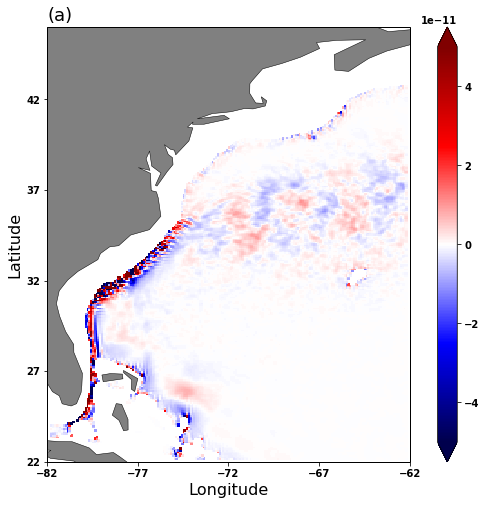

In [16]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
RV_dstm_w_xr.sel(st_ocean=400,method='nearest').plot(cmap='seismic',add_colorbar=True,vmin=-5e-11,vmax=5e-11)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

## Downstream Relative vorticity mean flow
\begin{equation}
\overline{\textbf{u}}\cdot\nabla\overline{\zeta}=\overline{u}\frac{\partial}{\partial x}(\overline\zeta)+\overline{v}\frac{\partial}{\partial y}(\overline{\zeta})
\end{equation}

or
\begin{equation}
\overline{\textbf{u}}\cdot\nabla\overline{\zeta}=\overline{u}\frac{\partial}{\partial x}(\overline\zeta)+\overline{v}\frac{\partial}{\partial y}(\overline{\zeta})+\overline{w}(\overline{\zeta})
\end{equation}


where

\begin{equation}
\overline{\zeta}=\overline{\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}}
\end{equation}

In [18]:
T=u.time.values

In [21]:
# grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
# dxu=grid.dxu.sel(xu_ocean=slice(-82, -62))\
#             .sel(yu_ocean=slice(22,46))
# dyu=grid.dyu.sel(xu_ocean=slice(-82, -62))\
#             .sel(yu_ocean=slice(22,46))
# dxunew=dxu[:,1:-1]
# dxdx=dxunew.values[:,0:-1]+dxunew.values[:,1:]
# dx_mean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
# dx3d=np.tile(dx_mean,[75,1,1])

# dyunew=dyu.values[1:-1,:]
# dydy=dyunew[0:-1,:]+dyunew[1:,:]
# dy_mean=1/2*(dydy[:,0:-1]+dydy[:,1:])
# dy_3d=np.tile(dy_mean,[75,1,1])
# xsize=dxunew.shape[1]-1
# ysize=dyunew.shape[0]-1

In [19]:
ubar=u.mean('time')
vbar=v.mean('time')
wbar=w.mean('time')
# U10_sl=ubar.sel(st_ocean=400,method='nearest')
# V10_sl=vbar.sel(st_ocean=400,method='nearest')
# X,Y=np.meshgrid(U10_sl['xu_ocean'].values,U10_sl['yu_ocean'].values)

In [21]:
ubar=u.mean('time')
vbar=v.mean('time')
wbar=w.mean('time')
RV_bar=np.zeros([zsize,ysize+2,xsize+2])
for i in T:
    print('computing'+str(i))
    RV=rv(u,v,i)
    RV_bar=RV_bar+RV.values/len(T)
RV_mean=xr.DataArray(RV_bar,coords=RV.coords)

In [33]:
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
dxu=grid.dxu.sel(xu_ocean=slice(-82, -62))\
            .sel(yu_ocean=slice(22,46))
dyu=grid.dyu.sel(xu_ocean=slice(-82, -62))\
            .sel(yu_ocean=slice(22,46))
dxunew=dxu[:,1:-1]
dxdx=dxunew.values[:,0:-1]+dxunew.values[:,1:]
dx_mean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
dx3d=np.tile(dx_mean,[75,1,1])


unew=ubar.values[:,:,1:-1]
dzeta=RV_mean.values[:,:,2:]-RV_mean.values[:,:,0:-2]
dzeta_dx=dzeta/dx3d
uu=1/2*(unew[:,1:,:]+unew[:,0:-1,:])
uu_mean=1/2*(uu[:,:,1:]+uu[:,:,0:-1])
URV_xg=xr.DataArray(uu_mean*dzeta_dx,coords=[RV_mean['st_ocean'],RV_mean['yt_ocean'],RV_mean['xt_ocean'][1:-1]])

vnew=vbar.values[:,1:-1,:]
dyunew=dyu.values[1:-1,:]
dzetay=RV_mean.values[:,2:,:]-RV_mean.values[:,0:-2,:]
dydy=dyunew[0:-1,:]+dyunew[1:,:]
dy_mean=1/2*(dydy[:,0:-1]+dydy[:,1:])
vv=1/2*(vnew[:,0:-1,:]+vnew[:,1:,:])
v_mean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
dy_3d=np.tile(dy_mean,[75,1,1])
VRV_yg=xr.DataArray(v_mean*dzetay/dy_3d,coords=[RV_mean['st_ocean'],RV_mean['yt_ocean'][1:-1],RV_mean['xt_ocean']])

z=ubar['st_ocean'].values
dz=z[1:]-z[0:-1]
dzdz=dzdz=dz[1:]+dz[0:-1]
dz3d=np.tile(dzdz,(wbar.shape[1],wbar.shape[2]-1,1))
dz3dd=np.transpose(dz3d,(2,0,1))
wnew=wbar.values[:,:,1:]
ww=1/2*(wnew[1:,:,:]+wnew[0:-1,:,:])
dzetaz=RV_mean.values[0:-2,:,:]-RV_mean.values[2:,:,:]
dzeta_dz=dzetaz/dz3dd
WRV_zg=xr.DataArray(ww[0:-1,:,:]*dzeta_dz,coords=[RV_mean['st_ocean'][1:-1],RV_mean['yt_ocean'],RV_mean['xt_ocean']])


RV_dstm=VRV_yg+URV_xg+WRV_zg

Text(0.0, 1.0, '(a)')

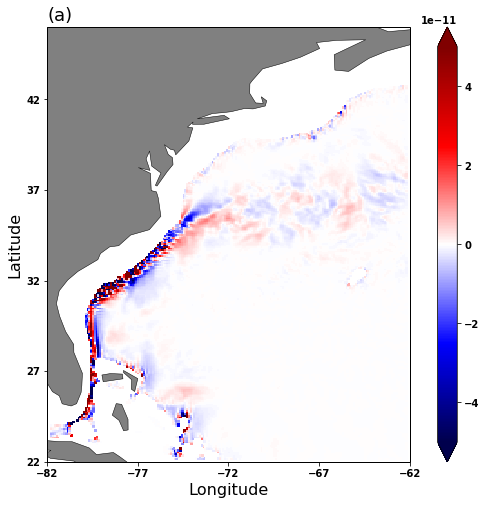

In [22]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
RV_dstm.sel(st_ocean=400,method='nearest').plot(cmap='seismic',add_colorbar=True,vmin=-5e-11,vmax=5e-11)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

## Downstream relative vorticity - variability
\begin{equation}
\overline{\textbf{u'}\cdot\nabla\zeta '} = \overline{\textbf{u}\cdot\nabla\zeta}-\overline{\textbf{u}}\cdot\nabla\overline{\zeta}
\end{equation}

In [23]:
RV_var=RV_dstm_w_xr-RV_dstm

Text(0.0, 1.0, '(a)')

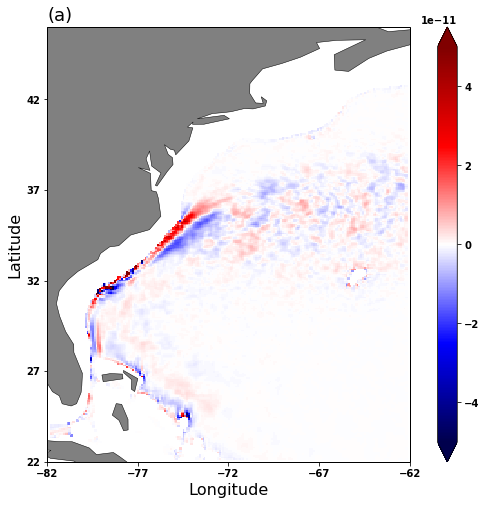

In [24]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
RV_var.sel(st_ocean=400,method='nearest').plot(cmap='seismic',add_colorbar=True,vmin=-5e-11,vmax=5e-11)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

### Buoyancy Freqency 

In [26]:
rho=cc.get_nc_variable(expt,'ocean.nc','pot_rho_2',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=gsx)\
                                 .sel(yt_ocean=gsy)\
                                 .sel(time=tgood)

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_pot_rho_2_None_days-since-0001-01-01_None_False.pkl


In [27]:
def buofre(rho,time):
    '''
    input time is one particular month
    '''
    xsize=rho.shape[3]-1
    ysize=rho.shape[2]
    z=rho['st_ocean'].values
    dz=z[1:zsize]-z[0:-1]
    dz3d=np.tile(dz,(ysize,xsize,1))
    dz3dd=np.transpose(dz3d,(2,0,1))
    rho1=rho.sel(time=time)[:,:,1:]
    drho=rho1.values[0:-1,:,:]-rho1.values[1:,:,:]
    drho_dz=drho/dz3dd
    buofre=xr.DataArray(drho_dz,coords=[rho['st_ocean'][0:-1],rho['yt_ocean'],rho['xt_ocean'][1:]])
    return buofre

In [39]:
dxunew=dxu[:,1:-1]
dxdx=dxunew.values[:,1:,]+dxunew.values[:,0:-1]
dx_mean=1/2*(dxdx[1:,:]+dxdx[0:-1,:])
dx3d=np.tile(dx_mean,[zsize-1,1,1])

dyunew=dyu[1:-1,:]
dydy=dyunew.values[1:,:]+dyunew.values[0:-1,:]
dy_mean=1/2*(dydy[:,1:]+dydy[:,0:-1])
dy_3d=np.tile(dy_mean,[zsize-1,1,1])
z=rho['st_ocean'].values
dz=z[1:]-z[0:-1]
dz3d=np.tile(dz[0:-1],(rho.shape[2],rho.shape[3]-1,1))
dz3dd=np.transpose(dz3d,(2,0,1))

#### Downstream whole 
\begin{equation}
\overline{\textbf{u}\cdot\nabla\frac{\partial\rho}{\partial z}}=\overline{u\frac{\partial}{\partial x}\frac{\partial\rho}{\partial z}+v\frac{\partial}{\partial y}\frac{\partial\rho}{\partial z}}
\end{equation}

In [30]:
xsize=rho.shape[3]-1
ysize=rho.shape[2]
buofre_ds_whole=np.zeros([zsize-1,ysize-2,xsize-2])
for i in T:
    print('computing'+str(i))
    u1=u.sel(time=i)
    u1new=u1[0:-1,:,1:-1]
    uu=1/2*(u1new.values[:,0:-1,:]+u1new.values[:,1:,:])
    uu_mean=1/2*(uu[:,:,0:-1]+uu[:,:,1:])
    
    v1=v.sel(time=i)
    v1new=v1.values[0:-1,1:-1,:]
    vv=1/2*(v1new[:,0:-1,:]+v1new[:,1:,:])
    v_mean=1/2*(vv[:,:,0:-1]+vv[:,:,0:-1])
    
    w1=w.sel(time=i)
    ww=1/2*(w1.values[0:-1,:,1:]+w1.values[1:,:,1:])
    
    bf=buofre(rho,i)
    
    bfx=bf
    dbx=bfx.values[:,:,2:]-bfx.values[:,:,0:-2]
    dbx_dx=dbx/dx3d
    bf_xg=xr.DataArray(uu_mean*dbx/dx3d,coords=[bf['st_ocean'],bf['yt_ocean'],bf['xt_ocean'][1:-1]])
    
    bfy=bf
    dbfy=bfy.values[:,2:,:]-bfy.values[:,0:-2,:]
    bf_yg=xr.DataArray(v_mean*dbfy/dy_3d,coords=[bf['st_ocean'],bf['yt_ocean'][1:-1],bf['xt_ocean']])
    
    
    #bfz=bf
    #dbfz=bfz.values[0:-1,:,:]-bfz.values[1:,:,:]
    #dbfz_dz=dbfz/dz3dd
    #bf_zg=xr.DataArray(ww[0:-1,:,:]*dbfz_dz,coords=[bfz['st_ocean'][0:-1],bfz['yt_ocean'],bfz['xt_ocean']])
    
    buofre_ds=bf_yg+bf_xg#+bf_zg
    buofre_ds_whole=buofre_ds_whole+buofre_ds.values/len(T)
buofre_ds_whole_xr=xr.DataArray(buofre_ds_whole,coords=buofre_ds.coords)
#buofre_ds_whole_xr1=xr.DataArray(buofre_ds_whole,coords=buofre_ds.coords)

Text(0.0, 1.0, '(a)')

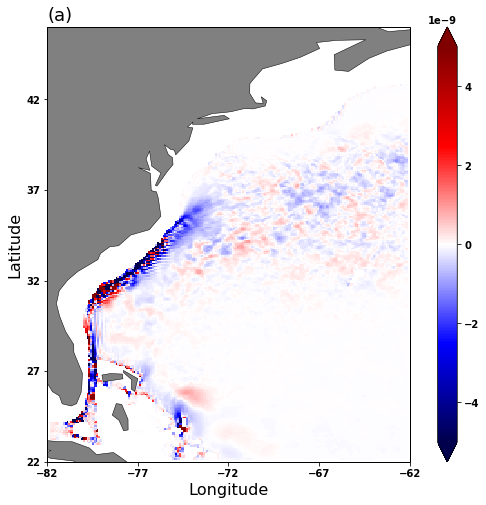

In [34]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
buofre_ds_whole_xr.sel(st_ocean=400,method='nearest').plot(cmap='seismic',add_colorbar=True,vmin=-5e-9,vmax=5e-9)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

#### Downstream buofre mean flow
\begin{equation}
\begin{aligned}
&\overline{\textbf{u}}\cdot\nabla\overline{\frac{\partial \rho}{\partial z}}\
=&\overline{u}\frac{\partial}{\partial x}\overline{\frac{\partial \rho}{\partial z}}+\overline{v}\frac{\partial}{\partial y}\overline{\frac{\partial \rho}{\partial z}}
\end{aligned}
\end{equation}

In [42]:
dz3d=np.tile(dz,(rho.shape[2],rho.shape[3]-1,1))
dz3dd=np.transpose(dz3d,(2,0,1))
rho1=rho.sel(time=tgood).mean('time')[:,:,1:]
drho=rho1.values[0:-1,:,:]-rho1.values[1:,:,:]
drho_dz=drho/dz3dd
bf_mean_xr=xr.DataArray(drho_dz,coords=[rho['st_ocean'][0:-1],rho['yt_ocean'],rho['xt_ocean'][1:]])

In [44]:
ubarnew=ubar[0:-1,:,1:-1]
uu=1/2*(ubarnew.values[:,0:-1,:]+ubarnew.values[:,1:,:])
uu_mean=1/2*(uu[:,:,0:-1]+uu[:,:,1:])

vbarnew=vbar.values[0:-1,1:-1,:]
vv=1/2*(vbarnew[:,0:-1,:]+vbarnew[:,1:,:])
v_mean=1/2*(vv[:,:,0:-1]+vv[:,:,0:-1])

bfx=bf_mean_xr
dbx=bfx.values[:,:,2:]-bfx.values[:,:,0:-2]
dbx_dx=dbx/dx3d
bf_xg=xr.DataArray(uu_mean*dbx/dx3d,coords=[bf_mean_xr['st_ocean'],
                                            bf_mean_xr['yt_ocean'],
                                            bf_mean_xr['xt_ocean'][1:-1]])
    
bfy=bf_mean_xr
dbfy=bfy.values[:,2:,:]-bfy.values[:,0:-2,:]
bf_yg=xr.DataArray(v_mean*dbfy/dy_3d,coords=[bf_mean_xr['st_ocean'],
                                             bf_mean_xr['yt_ocean'][1:-1],
                                             bf_mean_xr['xt_ocean']])
buofre_ds_mean=bf_yg+bf_xg

Text(0.0, 1.0, '(a)')

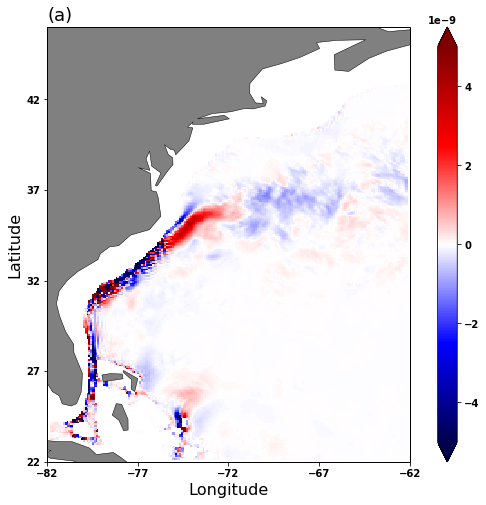

In [43]:
fig=plt.figure(figsize=(10,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
buofre_ds_mean.sel(st_ocean=400,method='nearest').plot(cmap='seismic',add_colorbar=True,vmin=-5e-9,vmax=5e-9)#,cbar_kwargs={'label': 'K','orientation':'vertical'})#
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)